In [47]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler


In [48]:
# function to read training and testing datasets and represent them in binary vectors

def vectorize_text(train_file, test_file):
    train_data = pd.read_table(train_file, names=['Activity', 'Features'])    # Read training data into activity and features
    features = train_data.iloc[:, 1]
    labels = train_data['Activity']
    test_data = pd.read_table(test_file, names=['Features'])    # Read test data

    # Creating and fitting the CountVectorizer for training data
    count_vectorizer = CountVectorizer(binary=True, tokenizer=lambda x: x.split())
    binary_features = count_vectorizer.fit_transform(train_data['Features']).toarray()

    # Transforming the test data
    test_binary_features = count_vectorizer.transform(test_data['Features']).toarray()

    return binary_features, labels, test_binary_features

train_file = 'train.txt'
test_file = 'test.txt'
train_features, train_labels, test_features = vectorize_text(train_file, test_file)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# checking the pre-processing and analysing the dataset
print(train_data)
print(features)
print(labels)


     Activity                                           Features
0           0  96 183 367 379 387 1041 1117 1176 1327 1546 18...
1           0  31 37 137 301 394 418 514 581 671 729 934 1006...
2           0  169 394 435 603 866 1418 1626 1744 1799 2179 2...
3           0  72 181 231 275 310 355 369 379 400 587 642 879...
4           0  37 379 453 503 547 611 684 716 794 866 1108 13...
..        ...                                                ...
795         1  39 120 345 400 412 558 729 1153 1176 1220 1287...
796         0  43 51 280 356 378 543 557 640 666 701 703 717 ...
797         0  63 232 360 405 433 447 474 751 1069 1168 1272 ...
798         0  83 159 290 462 505 509 531 547 737 969 1050 11...
799         0  91 432 433 509 559 578 1082 1153 1220 1758 185...

[800 rows x 2 columns]
0      96 183 367 379 387 1041 1117 1176 1327 1546 18...
1      31 37 137 301 394 418 514 581 671 729 934 1006...
2      169 394 435 603 866 1418 1626 1744 1799 2179 2...
3      72 181 231 275 310

In [327]:
target_count= train_data.Activity.value_counts()
pd.DataFrame({'Activity': target_count.index, 'Features': target_count.values})


,Activity,Features
0,0,722
1,1,78


In [ ]:
# checking missing values
print (len(features))
missing_values = train_data.isnull().sum()
print("Missing values",missing_values)

800
Missing values Activity    0
Features    0
dtype: int64


In [296]:
# count_vectorizer = CountVectorizer(binary=True, tokenizer=lambda x:x.split())
# binary_features = count_vectorizer.fit_transform(train_data['Features']).toarray()


In [49]:
# feature selection using chi-2 and SelectKBest
def select_features_chi2(train_features, train_labels, k):
    chi2_selector = SelectKBest(score_func=chi2, k=k)
    chi2_selector.fit(train_features, train_labels)
    selected_features = chi2_selector.get_support(indices=True)
    return selected_features

# retaining 90% of the features from the training set
fraction_to_keep = 0.90
total_features = train_features.shape[1]
num_features_to_keep = int(total_features * fraction_to_keep)


selected_feature_indices = select_features_chi2(train_features, train_labels, k=num_features_to_keep)
# selected_feature_names = count_vectorizer.get_feature_names_out(input_features=selected_feature_indices)
# print(selected_feature_names)
print(selected_feature_indices)

[    0     2     3 ... 84484 84485 84487]


In [50]:
print('Original feature number:', train_features.shape[1])
print('Reduced feature number:', train_features[:, selected_feature_indices].shape[1])

Original feature number: 84488
Reduced feature number: 76039


In [51]:
# Extract the selected features from the binary features matrix
selected_train_features = train_features[:, selected_feature_indices]
selected_test_features = test_features[:, selected_feature_indices]

In [52]:
# checking the dimensions of the reduced features and labels are compatible
print("Shape of selected_binary_features:", selected_train_features.shape)
print("Shape of labels:", train_labels.shape)
print(selected_test_features.shape)

Shape of selected_binary_features: (800, 76039)
Shape of labels: (800,)
(350, 76039)


In [12]:
# naive Bayes Classification
from sklearn.naive_bayes import BernoulliNB
naive_bayes = BernoulliNB()
X_train, X_valid, y_train, y_valid = train_test_split(train_features, train_labels, test_size=0.2, random_state=42,stratify=train_labels)
# Train the classifier on the training data
naive_bayes.fit(train_features, train_labels)
pred_bayes = naive_bayes.predict(X_valid)
f1_train_naive =f1_score(y_valid,pred_bayes)
print("F1-score for Naive bayes:", f1_train_naive)

F1-score for Naive bayes: 0.4166666666666667


In [43]:

# Perform oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_over_sample, y_over_sample = ros.fit_resample(selected_train_features, train_labels)

# Perform under-sampling
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_under_sample, y_under_sample = rus.fit_resample(X_train, y_train)

# Split the oversampled data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_over_sample, y_over_sample, test_size=0.2, random_state=42)


# Cost-complexity pruning path
dt_clf = DecisionTreeClassifier(criterion='gini')
path = dt_clf.cost_complexity_pruning_path(X_train, y_train)
alphas, impurity = path.ccp_alphas, path.impurities
alphas = alphas[:-1]

# Initialize variables to keep track of the best F1 score and best classifier
best_f1_score = 0
best_classifier = None

# Iterate through the trained decision trees and calculate F1 scores
clfs = []
for alpha in alphas:
    d_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    d_tree.fit(X_train, y_train)
    clfs.append(d_tree)

    # Calculate F1 score on the validation set
    y_pred = d_tree.predict(X_valid)
    f1 = f1_score(y_valid, y_pred)

    # Check if this classifier has a better F1 score than the current best
    if f1 > best_f1_score:
        best_f1_score = f1
        best_classifier = d_tree

print("Best F1-score after cost-complexity pruning and oversampling:", best_f1_score)


Best F1-score after cost-complexity pruning and oversampling: 0.9897610921501706


In [46]:
best_classifier.fit(X_over_sample, y_over_sample)
predictions = best_classifier.predict(selected_test_features)


In [63]:
X_train, X_valid, y_train, y_valid = train_test_split(selected_train_features, train_labels, shuffle=True, test_size=0.2, random_state=42, stratify=train_labels)
ros = RandomOverSampler(random_state=42)
Xresam,yresam=ros.fit_resample(selected_train_features,train_labels)

# initializing the decision tree
decision_tree = DecisionTreeClassifier(criterion='gini',random_state=42, ccp_alpha=0.05)

decision_tree.fit(Xresam,yresam)
pred_tree = decision_tree.predict(X_valid)
f1_train =f1_score(y_valid,pred_tree)
print("F1-score for Decision Tree (over sampling):", f1_train)

# predicting for test dataset
prediction = decision_tree.predict(selected_test_features)

F1-score for Decision Tree (over sampling): 0.7096774193548386


In [64]:
# Writing the test predictions to a file in the required format
test_predictions_file = '/content/test_predictions.txt'
with open(test_predictions_file, "w") as f:
    for p in prediction:
        f.write(f"{p}\n")

In [247]:
# # predicting for test dataset
# count_vectorizer_test = CountVectorizer(binary=True, tokenizer=lambda x:x.split())
# test_binary_features = count_vectorizer.transform(test_data['Features']).toarray()
# prediction = best_classifier.predict(test_binary_features)

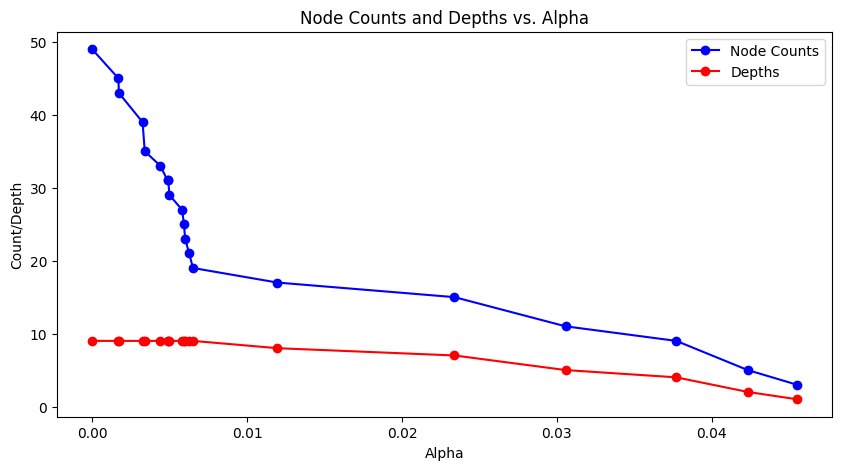

In [43]:
# Initialize lists to store node counts and depths
node_counts = []
depths = []

for clf in clfs:
    node_count = clf.tree_.node_count
    tree_depth = clf.tree_.max_depth
    node_counts.append(node_count)
    depths.append(tree_depth)

# Plot the node counts and depths against alpha values
plt.figure(figsize=(10, 5))
plt.plot(alphas, node_counts, marker='o', linestyle='-', color='b', label='Node Counts')
plt.plot(alphas, depths, marker='o', linestyle='-', color='r', label='Depths')
plt.xlabel('Alpha')
plt.ylabel('Count/Depth')
plt.title('Node Counts and Depths vs. Alpha')
plt.legend()
plt.show()

In [326]:
# Print the alpha values, node counts, and depths
for alpha, node_count, tree_depth in zip(alphas, node_counts, depths):
    print(f"Alpha: {alpha}, Node Count: {node_count}, Depth: {tree_depth}")

Alpha: 0.0, Node Count: 49, Depth: 9
Alpha: 0.0016079158936301797, Node Count: 45, Depth: 9
Alpha: 0.0016848016848016864, Node Count: 43, Depth: 9
Alpha: 0.0016922471467926009, Node Count: 39, Depth: 9
Alpha: 0.0017265680056377842, Node Count: 35, Depth: 9
Alpha: 0.00277056277056277, Node Count: 33, Depth: 9
Alpha: 0.0034035219881250376, Node Count: 31, Depth: 9
Alpha: 0.0034504944596687502, Node Count: 31, Depth: 9
Alpha: 0.004155844155844155, Node Count: 29, Depth: 9
Alpha: 0.004863221884498479, Node Count: 27, Depth: 9
Alpha: 0.004961065948792412, Node Count: 25, Depth: 9
Alpha: 0.0060638856093401545, Node Count: 23, Depth: 9
Alpha: 0.010158730158730159, Node Count: 21, Depth: 9
Alpha: 0.010782959773785496, Node Count: 19, Depth: 9
Alpha: 0.01546503441240284, Node Count: 17, Depth: 8
Alpha: 0.018741036603844276, Node Count: 15, Depth: 7
Alpha: 0.022405896326292543, Node Count: 11, Depth: 5
Alpha: 0.03159209555540078, Node Count: 9, Depth: 4
Alpha: 0.03802657005163384, Node Count: 5,

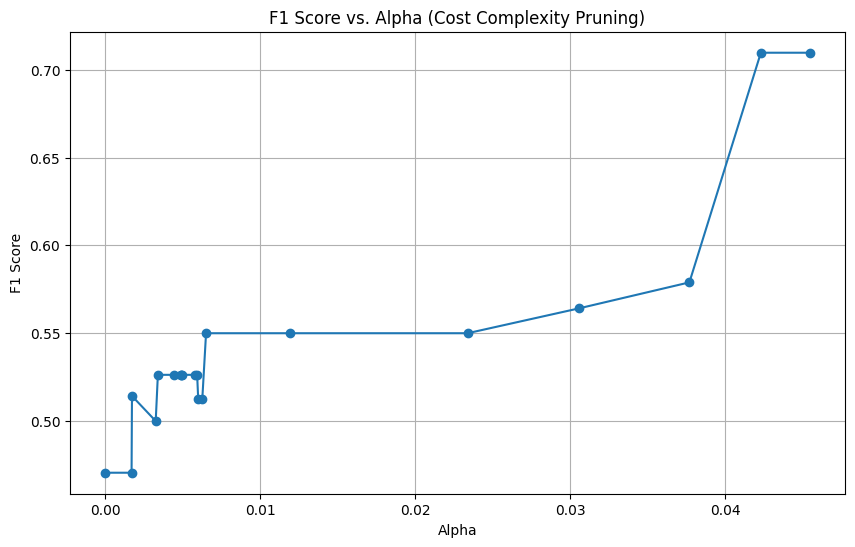

In [35]:
# Initialize lists to store F1 scores and alpha values
f1_scores = []
alpha_values = []

# Iterate through the trained decision trees and calculate F1 scores
for alpha, clf in zip(alphas, clfs):
    y_pred = clf.predict(X_valid)
    f1 = f1_score(y_valid, y_pred)
    f1_scores.append(f1)
    alpha_values.append(alpha)

# Plot the F1 scores against alpha values
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, f1_scores, marker='o', linestyle='-')
plt.title('F1 Score vs. Alpha (Cost Complexity Pruning)')
plt.xlabel('Alpha')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()
